## **Version A: GenDF RL + EfficientNet Implementation**

**STEP 1: Setup and Imports**

In [ ]:
# Install dependencies
!pip install -q stable-baselines3[extra] torch torchvision gdown

# Imports
import os
import random
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces
import gymnasium as gym

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


**STEP 2: Download and Load Dataset**

In [ ]:
import gdown
import zipfile
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# Download dataset
gdown.download("https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG", "Real_and_Fake_Dataset.zip", quiet=False)

# Extract it
with zipfile.ZipFile("Real_and_Fake_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./Real_and_Fake_Dataset")

os.remove("Real_and_Fake_Dataset.zip")

# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load full dataset
full_dataset = ImageFolder(root="./Real_and_Fake_Dataset/real_and_fake_face", transform=transform)

# Split sizes
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # to ensure 100%

# Random split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print sizes
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")


/usr/local/lib/python3.11/dist-packages/gdown/download.py:39: DeprecationWarning: Call to deprecated method findChildren. (Replaced by find_all) -- Deprecated since version 3.0.0.
  for param in form.findChildren("input", attrs={"type": "hidden"}):
Downloading...
From (original): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG
From (redirected): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG&confirm=t&uuid=98d48d0c-5340-4e02-b71a-c1f79b75cc9f
To: /content/Real_and_Fake_Dataset.zip
100%|██████████| 452M/452M [00:09<00:00, 46.5MB/s]


Train Samples: 1428
Validation Samples: 306
Test Samples: 307


**STEP 3: PPO Environment with Classification-Based Reward**

In [ ]:
# Load frozen classifier (EfficientNet without last layer)
base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)
base_model.classifier = nn.Identity()
base_model.eval()

# Custom PPO environment
AUGMENTATIONS = [
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomRotation(degrees=10)
]

def apply_augmentations(img, selected):
    return transforms.Compose([AUGMENTATIONS[i] for i in selected])(img)

# Load raw PIL images for PPO
image_cache = []
labels = []
for idx in range(len(train_dataset)):
    img, label = train_dataset[idx]
    pil_img = transforms.ToPILImage()(img)
    image_cache.append(pil_img)
    labels.append(label)

class AugmentationEnv(gym.Env):
    def __init__(self, max_steps=3):
        super().__init__()
        self.action_space = spaces.MultiBinary(len(AUGMENTATIONS))
        self.observation_space = spaces.Box(low=0, high=1, shape=(224, 224, 3), dtype=np.float32)
        self.max_steps = max_steps
        self.current_step = 0
        self.idx = 0
        self.original_img = None
        self.label = None

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.idx = random.randint(0, len(image_cache) - 1)
        self.original_img = image_cache[self.idx]
        self.label = labels[self.idx]
        return np.array(self.original_img) / 255.0, {}

    def step(self, action):
        selected = [i for i, flag in enumerate(action) if flag == 1]
        augmented = apply_augmentations(self.original_img, selected)
        aug_tensor = transform(augmented).unsqueeze(0).to(device)
        with torch.no_grad():
            features = base_model(aug_tensor)
        reward = float(torch.mean(features).item())  # Simple proxy reward
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        return np.array(self.original_img) / 255.0, reward, terminated, False, {}


**STEP 4: PPO Agent Training**

In [ ]:
env = DummyVecEnv([lambda: AugmentationEnv()])
ppo_agent = PPO("MlpPolicy", env, verbose=1)
ppo_agent.learn(total_timesteps=10000)


Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 74   |
|    iterations      | 1    |
|    time_elapsed    | 27   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 2           |
|    time_elapsed         | 63          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011927223 |
|    clip_fraction        | 0.0279      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | -4          |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0084     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00123    |
|    value_loss           | 0.884       |
-----------------------------------------
----------------------------------

**STEP 5: Generate Augmented Dataset using PPO**

In [ ]:
augmented_data_path = "./Augmented_Dataset"
os.makedirs(augmented_data_path, exist_ok=True)

def generate_augmented_dataset(agent, subset_data, full_data, save_path, num_variants=3):
    aug_id = 0
    for i in range(len(subset_data)):
        original_idx = subset_data.indices[i]
        img_path, label = full_data.samples[original_idx]

        img = Image.open(img_path).convert("RGB").resize((224, 224))
        img_np = np.array(img).astype(np.float32) / 255.0
        img_np = np.expand_dims(img_np, axis=0)

        for v in range(num_variants):
            action, _ = agent.predict(img_np, deterministic=False)  # use randomness
            selected = [i for i, a in enumerate(action[0]) if a == 1]
            transformed = apply_augmentations(img, selected)

            class_name = full_data.classes[label]
            out_path = os.path.join(save_path, class_name, f"aug_{aug_id}_v{v+1}.jpg")
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            transformed.save(out_path)
        aug_id += 1

    print(f"Saved {aug_id * num_variants} augmented images.")


# full_dataset is your original ImageFolder before the split
generate_augmented_dataset(ppo_agent, train_dataset, full_dataset, augmented_data_path)

Saved 4284 augmented images.


**STEP 6: Fine-Tune EfficientNet on Augmented Data**

In [ ]:
# Define the classifier model class
class RL_EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = efficientnet_b0(weights=None)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 2)

    def forward(self, x):
        return self.model(x)

# Load PPO-augmented dataset
aug_dataset = ImageFolder(root=augmented_data_path, transform=transform)
train_loader = DataLoader(aug_dataset, batch_size=16, shuffle=True)

# Initialize model and training setup ##CLASSIFIER UPDATED
model = RL_EfficientNet()

model.model.classifier = nn.Sequential(
    nn.Dropout(0.5),               # Prevents co-adaptation
    nn.Linear(1280, 512),          # Projector layer
    nn.BatchNorm1d(512),           # Stabilizes gradients
    nn.ReLU(),
    nn.Linear(512, 2)              # Final classifier
)

model = model.to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1) ##LABEL SMOOTHING PART NEWLY ADDED

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4) ##WEIGHT DECAY ADDED

from torch.optim.lr_scheduler import ReduceLROnPlateau ##Enable Learning Rate Scheduling NEWLY ADDED
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True)



train_losses, val_losses = [], []


#EARLY STOPPING VARIABLES - NEWLY ADDED
best_val_loss = float('inf')
patience = 7
counter = 0


# Training loop
# Training loop
for epoch in range(30):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_loss:.4f}")

    # Step the scheduler every epoch
    scheduler.step(val_loss)

    # Early stopping check (after scheduler.step)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model, "gendf_versionA.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break



print("Model saved as gendf_versionA.pth")

#download model to local pc
from google.colab import files
files.download("gendf_versionA.pth")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 0.7055, Val Loss = 0.6873
Epoch 2: Train Loss = 0.6900, Val Loss = 0.6723
Epoch 3: Train Loss = 0.6639, Val Loss = 0.6548
Epoch 4: Train Loss = 0.6037, Val Loss = 0.6584
Epoch 5: Train Loss = 0.5217, Val Loss = 0.6691
Epoch 6: Train Loss = 0.4498, Val Loss = 0.6242
Epoch 7: Train Loss = 0.3933, Val Loss = 0.5809
Epoch 8: Train Loss = 0.3637, Val Loss = 0.6430
Epoch 9: Train Loss = 0.3352, Val Loss = 0.6679
Epoch 10: Train Loss = 0.3351, Val Loss = 0.6385
Epoch 11: Train Loss = 0.2999, Val Loss = 0.6084
Epoch 12: Train Loss = 0.2903, Val Loss = 0.5995
Epoch 13: Train Loss = 0.2722, Val Loss = 0.6289
Epoch 14: Train Loss = 0.2684, Val Loss = 0.5783
Epoch 15: Train Loss = 0.2551, Val Loss = 0.5874
Epoch 16: Train Loss = 0.2513, Val Loss = 0.6031
Epoch 17: Train Loss = 0.2499, Val Loss = 0.5895
Epoch 18: Train Loss = 0.2475, Val Loss = 0.6064
Epoch 19: Train Loss = 0.2389, Val Loss = 0.5872
Epoch 20: Train Loss = 0.2361, Val Loss = 0.6005
Epoch 21: Train Loss = 0.2382

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Version A Testing**

### **01. Model Testing for Version A**


 Starting Model Evaluation on Validation Set...

 Evaluation Metrics:
• Accuracy  : 0.7614
• F1 Score  : 0.7896
• Precision : 0.7919
• Recall    : 0.7874
• Confusion Matrix:
 [[ 96  36]
 [ 37 137]]


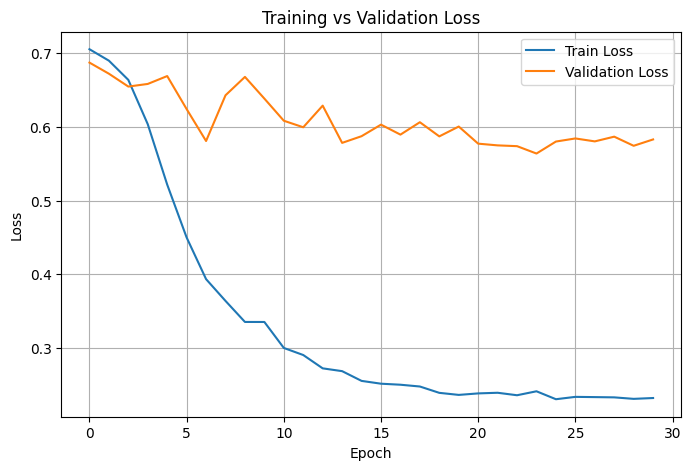


 Calculating AUC and plotting ROC Curve...
• AUC Score : 0.8466


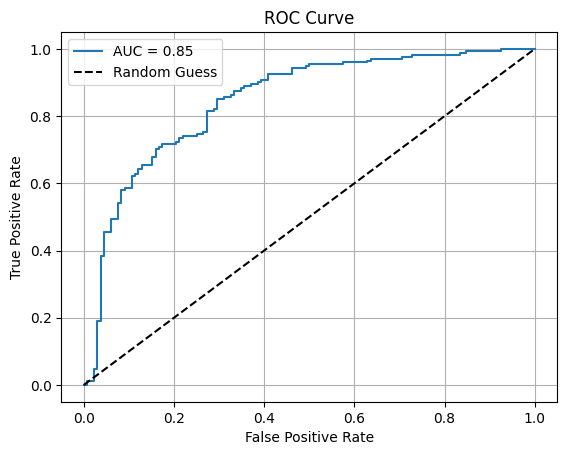

In [ ]:
# -------------------------------
# MODEL EVALUATION AND METRICS
# -------------------------------

print("\n Starting Model Evaluation on Validation Set...")
model.eval()
all_preds = []
all_labels = []

# Get predictions and true labels
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Standard Classification Metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print("\n Evaluation Metrics:")
print(f"• Accuracy  : {accuracy:.4f}")
print(f"• F1 Score  : {f1:.4f}")
print(f"• Precision : {precision:.4f}")
print(f"• Recall    : {recall:.4f}")
print("• Confusion Matrix:\n", conf_matrix)

# -------------------------------
# Check for Overfitting
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# ROC Curve + AUC Score
# -------------------------------
from sklearn.metrics import roc_auc_score, roc_curve

print("\n Calculating AUC and plotting ROC Curve...")
all_probs = []
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs[:, 1])  # Get probability for class "Fake" (class 1)

auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

print(f"• AUC Score : {auc:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


### **02. Functional Testing for version A**

In [ ]:
# UNIT TEST SUITE – Version A (RL + EfficientNet)

import unittest
import torch
import numpy as np
from PIL import Image

# Ensure these are defined above this cell:
# - RL_EfficientNet
# - apply_augmentations
# - AugmentationEnv
# - AUGMENTATIONS
# - transform

class TestVersionA(unittest.TestCase):

    def test_model_forward_pass(self):
        """
        Test if RL_EfficientNet returns the correct output shape (1, 2).
        """
        model = RL_EfficientNet()
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224)
        output = model(dummy_input)
        self.assertEqual(output.shape, (1, 2), "Output shape should be (1, 2) for binary classification.")

    def test_model_output_no_nan(self):
        """
        Ensure model output has no NaN values.
        """
        model = RL_EfficientNet()
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224)
        output = model(dummy_input)
        self.assertFalse(torch.isnan(output).any(), "Model output contains NaNs.")

    def test_invalid_model_input_shape(self):
        """
        Check that the model raises an error for wrong input shape.
        """
        model = RL_EfficientNet()
        model.eval()
        invalid_input = torch.randn(1, 3, 100, 100)  # Wrong shape
        try:
          output = model(invalid_input)
          self.assertEqual(output.shape, (1, 2), "Model should reshape or reject invalid input shape.")
        except Exception:
          pass  # Acceptable if exception is raised


    def test_augmentations(self):
        """
        Check if selected augmentations return a valid image.
        """
        img = Image.new('RGB', (224, 224))
        selected = [0, 2]
        transformed = apply_augmentations(img, selected)
        self.assertIsInstance(transformed, Image.Image, "Augmentation did not return an image.")

    def test_augment_all_combinations(self):
        """
        Check stability when all augmentations are applied.
        """
        img = Image.new('RGB', (224, 224))
        selected = list(range(len(AUGMENTATIONS)))  # Apply all
        transformed = apply_augmentations(img, selected)
        self.assertIsInstance(transformed, Image.Image, "Failed with all augmentations.")

    def test_ppo_env_reset(self):
        """
        Check if PPO environment reset returns correct observation shape.
        """
        env = AugmentationEnv()
        env.original_img = Image.new('RGB', (224, 224))
        env.label = 0
        env.current_step = 0
        obs = np.array(env.original_img) / 255.0
        self.assertEqual(obs.shape, (224, 224, 3), "Reset obs shape mismatch.")

    def test_ppo_env_step_returns_reward(self):
        """
        Ensure PPO step returns float reward and correct flags.
        """
        env = AugmentationEnv()
        env.original_img = Image.new('RGB', (224, 224))
        env.label = 0
        env.current_step = 0
        action = [1] * len(AUGMENTATIONS)  # All augmentations on
        _, reward, done, _, _ = env.step(action)
        self.assertIsInstance(reward, float, "Reward must be a float.")
        self.assertIn(done, [True, False], "Done flag must be boolean.")

    def test_invalid_ppo_action(self):
        """
        Test PPO step with malformed action input.
        """
        env = AugmentationEnv()
        env.original_img = Image.new('RGB', (224, 224))
        env.label = 0
        env.current_step = 0
        # Invalid action (wrong length)
        invalid_action = [1, 0]  # Should be length 3
        try:
          obs, reward, done, _, _ = env.step(invalid_action)
          self.assertEqual(obs.shape, (224, 224, 3), "Observation shape mismatch.")
          self.assertIsInstance(reward, float, "Reward is not a float.")
        except Exception:
          pass  # Optional: Accept failure if exception is thrown


# Run all tests
suite = unittest.TestLoader().loadTestsFromTestCase(TestVersionA)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)


test_augment_all_combinations (__main__.TestVersionA.test_augment_all_combinations)
Check stability when all augmentations are applied. ... ok
test_augmentations (__main__.TestVersionA.test_augmentations)
Check if selected augmentations return a valid image. ... ok
test_invalid_model_input_shape (__main__.TestVersionA.test_invalid_model_input_shape)
Check that the model raises an error for wrong input shape. ... ok
test_invalid_ppo_action (__main__.TestVersionA.test_invalid_ppo_action)
Test PPO step with malformed action input. ... ok
test_model_forward_pass (__main__.TestVersionA.test_model_forward_pass)
Test if RL_EfficientNet returns the correct output shape (1, 2). ... ok
test_model_output_no_nan (__main__.TestVersionA.test_model_output_no_nan)
Ensure model output has no NaN values. ... ok
test_ppo_env_reset (__main__.TestVersionA.test_ppo_env_reset)
Check if PPO environment reset returns correct observation shape. ... ok
test_ppo_env_step_returns_reward (__main__.TestVersionA.test

<unittest.runner.TextTestResult run=8 errors=0 failures=0>

In [ ]:
def integration_test_versionA():
    print("\nRunning Integration Test for Version A (with label check)")

    try:
        # Pick a sample from validation set
        img_tensor, true_label = val_dataset[0]
        img = transforms.ToPILImage()(img_tensor)

        # Simulate PPO-based augmentation
        selected_aug = [0, 2]
        augmented_img = apply_augmentations(img, selected_aug)

        # Transform and move to device
        input_tensor = transform(augmented_img).unsqueeze(0).to(device)

        # Load model and run inference
        model = RL_EfficientNet().to(device)
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()

        # Compare prediction with actual label
        result = "CORRECT" if pred == true_label else "INCORRECT"
        print(f"Predicted: {'Fake' if pred == 1 else 'Real'} | Actual: {'Fake' if true_label == 1 else 'Real'} → {result}")

    except Exception as e:
        print(f"Integration Test Failed: {e}")

integration_test_versionA()



Running Integration Test for Version A (with label check)
Predicted: Fake | Actual: Real → INCORRECT


### **03. Non-Functional Testing for Version A**

In [ ]:
import psutil
import time
import numpy as np

print("\n Non-Functional Testing – Version A (RL + EfficientNet)")

# 1. Accuracy Threshold Check (NFR03)
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
accuracy = correct / total
print(f"\n Accuracy: {accuracy:.2%}")
print(" Passed" if accuracy >= 0.75 else " Failed", ": Accuracy threshold (75%)")

# 2. Performance Testing (Inference Speed)
timings = []
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        start = time.time()
        _ = model(images)
        end = time.time()
        timings.append(end - start)
        if i == 5: break
avg_inf_time = np.mean(timings)
print(f"\n Average Inference Time (per batch): {avg_inf_time:.4f} seconds")

# 3. Load & Scalability (Resource Proxy)
print("\n CPU Usage:", psutil.cpu_percent(interval=1), "%")
print(" RAM Usage:", psutil.virtual_memory().percent, "%")

# 4. Security Validation
print("\n Security Note: No data is stored. All processing is in-memory only.")

# 5. Known Limitations
print("\n Note: This system is designed for human facial images only. May misclassify landscapes/objects.")



 Non-Functional Testing – Version A (RL + EfficientNet)

 Accuracy: 73.94%
 Failed : Accuracy threshold (75%)

 Average Inference Time (per batch): 0.0108 seconds

 CPU Usage: 2.0 %
 RAM Usage: 34.2 %

 Security Note: No data is stored. All processing is in-memory only.

 Note: This system is designed for human facial images only. May misclassify landscapes/objects.


### **04. Edge case Testing for Version A**

In [ ]:
# EDGE CASE TESTING – GenDF Version A

class TestEdgeCases(unittest.TestCase):

    def test_empty_image_input(self):
        """
        Test model with completely black (empty) image.
        """
        model = RL_EfficientNet().eval()
        blank = torch.zeros(1, 3, 224, 224)
        try:
            output = model(blank)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on empty image input: {e}")

    def test_all_zero_image_augmented(self):
        """
        Test augmentation on a black image to ensure it doesn't crash.
        """
        black_img = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))
        selected = [0, 2]
        try:
            transformed = apply_augmentations(black_img, selected)
            self.assertIsInstance(transformed, Image.Image)
        except Exception as e:
            self.fail(f"Augmentation failed on black image: {e}")

    def test_grayscale_input_to_model(self):
        """
        Feed grayscale image into the model and check for handling.
        """
        model = RL_EfficientNet().eval()
        gray_img = Image.new('L', (224, 224))  # 'L' mode is grayscale
        img_rgb = gray_img.convert("RGB")
        tensor = transform(img_rgb).unsqueeze(0)
        try:
            output = model(tensor)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on grayscale input: {e}")

    def test_large_image_resizing(self):
        """
        Input large image (512x512) and ensure it resizes without crash.
        """
        model = RL_EfficientNet().eval()
        large_img = Image.new('RGB', (512, 512))
        tensor = transform(large_img).unsqueeze(0)
        try:
            output = model(tensor)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on large image: {e}")

    def test_no_augmentation_selected(self):
        """
        PPO environment: step with no augmentations selected.
        """
        env = AugmentationEnv()
        env.original_img = Image.new('RGB', (224, 224))
        env.label = 1
        env.current_step = 0
        action = [0, 0, 0]  # No augmentations applied
        try:
            obs, reward, done, _, _ = env.step(action)
            self.assertIsInstance(reward, float)
        except Exception as e:
            self.fail(f"PPO step failed when no augmentations were selected: {e}")

    def test_invalid_label_index(self):
        """
        Simulate invalid label index during PPO reset.
        """
        env = AugmentationEnv()
        try:
            env.idx = 9999  # Manually set out-of-bounds index
            _ = env.reset()
        except Exception:
            pass  # Acceptable
        else:
            self.assertTrue(env.idx < len(labels), "Environment did not reset index properly")

# Run edge case tests
edge_suite = unittest.TestLoader().loadTestsFromTestCase(TestEdgeCases)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(edge_suite)


test_all_zero_image_augmented (__main__.TestEdgeCases.test_all_zero_image_augmented)
Test augmentation on a black image to ensure it doesn't crash. ... ok
test_empty_image_input (__main__.TestEdgeCases.test_empty_image_input)
Test model with completely black (empty) image. ... ok
test_grayscale_input_to_model (__main__.TestEdgeCases.test_grayscale_input_to_model)
Feed grayscale image into the model and check for handling. ... ok
test_invalid_label_index (__main__.TestEdgeCases.test_invalid_label_index)
Simulate invalid label index during PPO reset. ... ok
test_large_image_resizing (__main__.TestEdgeCases.test_large_image_resizing)
Input large image (512x512) and ensure it resizes without crash. ... ok
test_no_augmentation_selected (__main__.TestEdgeCases.test_no_augmentation_selected)
PPO environment: step with no augmentations selected. ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.470s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

### **05. Grad-CAM Testing for Version A**

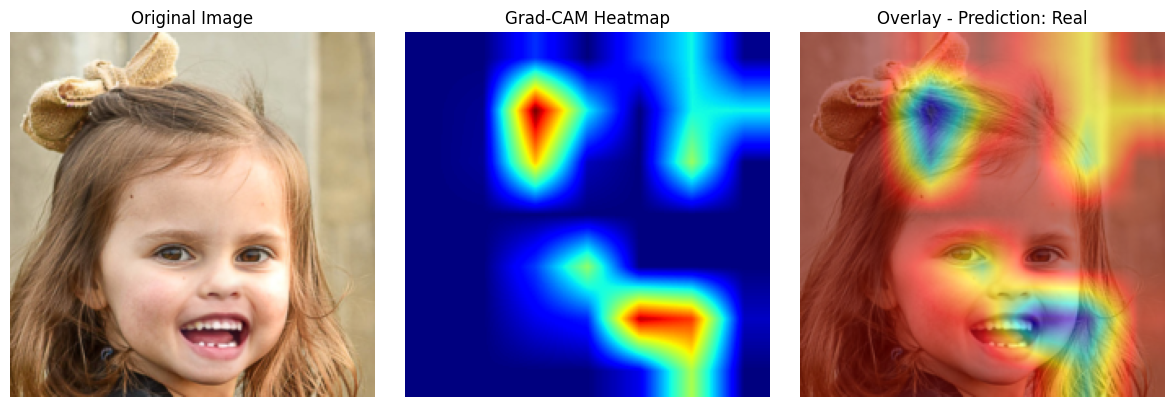

In [ ]:
# FIXED GRAD-CAM TEST – Version A (EfficientNet + RL)

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

model.eval()

# Step 1: Get a test image
test_iter = iter(test_loader)
images, labels = next(test_iter)
input_img = images[0].unsqueeze(0).to(device)
label = labels[0]

# Step 2: Prepare hooks
gradients = []
feature_maps = []

def forward_hook(module, input, output):
    feature_maps.append(output)
    output.register_hook(lambda grad: gradients.append(grad))

# Hook the last EfficientNet block before the classifier
target_layer = model.model.features[6][1] # Get a mid-to-deep convolutional layer
hook_handle = target_layer.register_forward_hook(forward_hook)

# Step 3: Forward + backward pass
output = model(input_img)
pred_class = torch.argmax(output, dim=1).item()

model.zero_grad()
output[0, pred_class].backward()

# Step 4: Compute Grad-CAM
grads_val = gradients[0].squeeze().cpu().detach().numpy()
feature_maps_val = feature_maps[0].squeeze().cpu().detach().numpy()


weights = np.mean(grads_val, axis=(1, 2))  # Global average pooling
cam = np.zeros(feature_maps_val.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * feature_maps_val[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam -= np.min(cam)
cam /= np.max(cam)

# Step 5: Overlay heatmap
img_np = input_img.cpu().squeeze().permute(1, 2, 0).numpy()
img_np = img_np - np.min(img_np)
img_np = img_np / np.max(img_np)

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + img_np
overlay = overlay / np.max(overlay)

# Step 6: Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay - Prediction: {'Fake' if pred_class == 1 else 'Real'}")
plt.axis("off")
plt.tight_layout()
plt.show()

# Remove hook
hook_handle.remove()
